# Create design matrix
First, get a list of the BOLD data (factor maps for each subject) and make sure it is ordered correctly.

In [1]:
import glob
import re

factor_maps_out = "/oak/stanford/groups/russpold/data/uh2/aim1/derivatives/output_surveyMedley_noderivs_rerun/factor_weighted_averages"
bold_files = glob.glob(f"{factor_maps_out}/*")
num_factors = 6
sub_ids = sorted(set([re.search('_sub_(.*).nii.gz', val).group(1) for val in bold_files]))
print(sub_ids) # check that it's sorted correctly

sorted_bold_files = []
for sub in sub_ids:
    for i in range(num_factors):
        sorted_bold_files.append(f"{factor_maps_out}/factor_{i+1}_weighted_avg_sub_{sub}.nii.gz")
print("Number of BOLD files:", len(sorted_bold_files))

['130', '172', '192', '234', '465', '518', '519', '524', '526', '546', '548', '549', '553', '554', '555', '557', '558', '561', '567', '570', '572', '574', '577', '582', '583', '584', '585', '586', '587', '589', '590', '591', '592', '593', '594', '595', '596', '601', '602', '604', '606', '607', '608', '609', '611', '612', '613', '614', '616', '619', '621', '622', '626', '628', '629', '633', '636', '637', '638', '641', '642', '643', '645', '646', '647', '648']
Number of BOLD files: 396


Next, create the design matrix.

rank: 71
number of columns in design matrix: 71


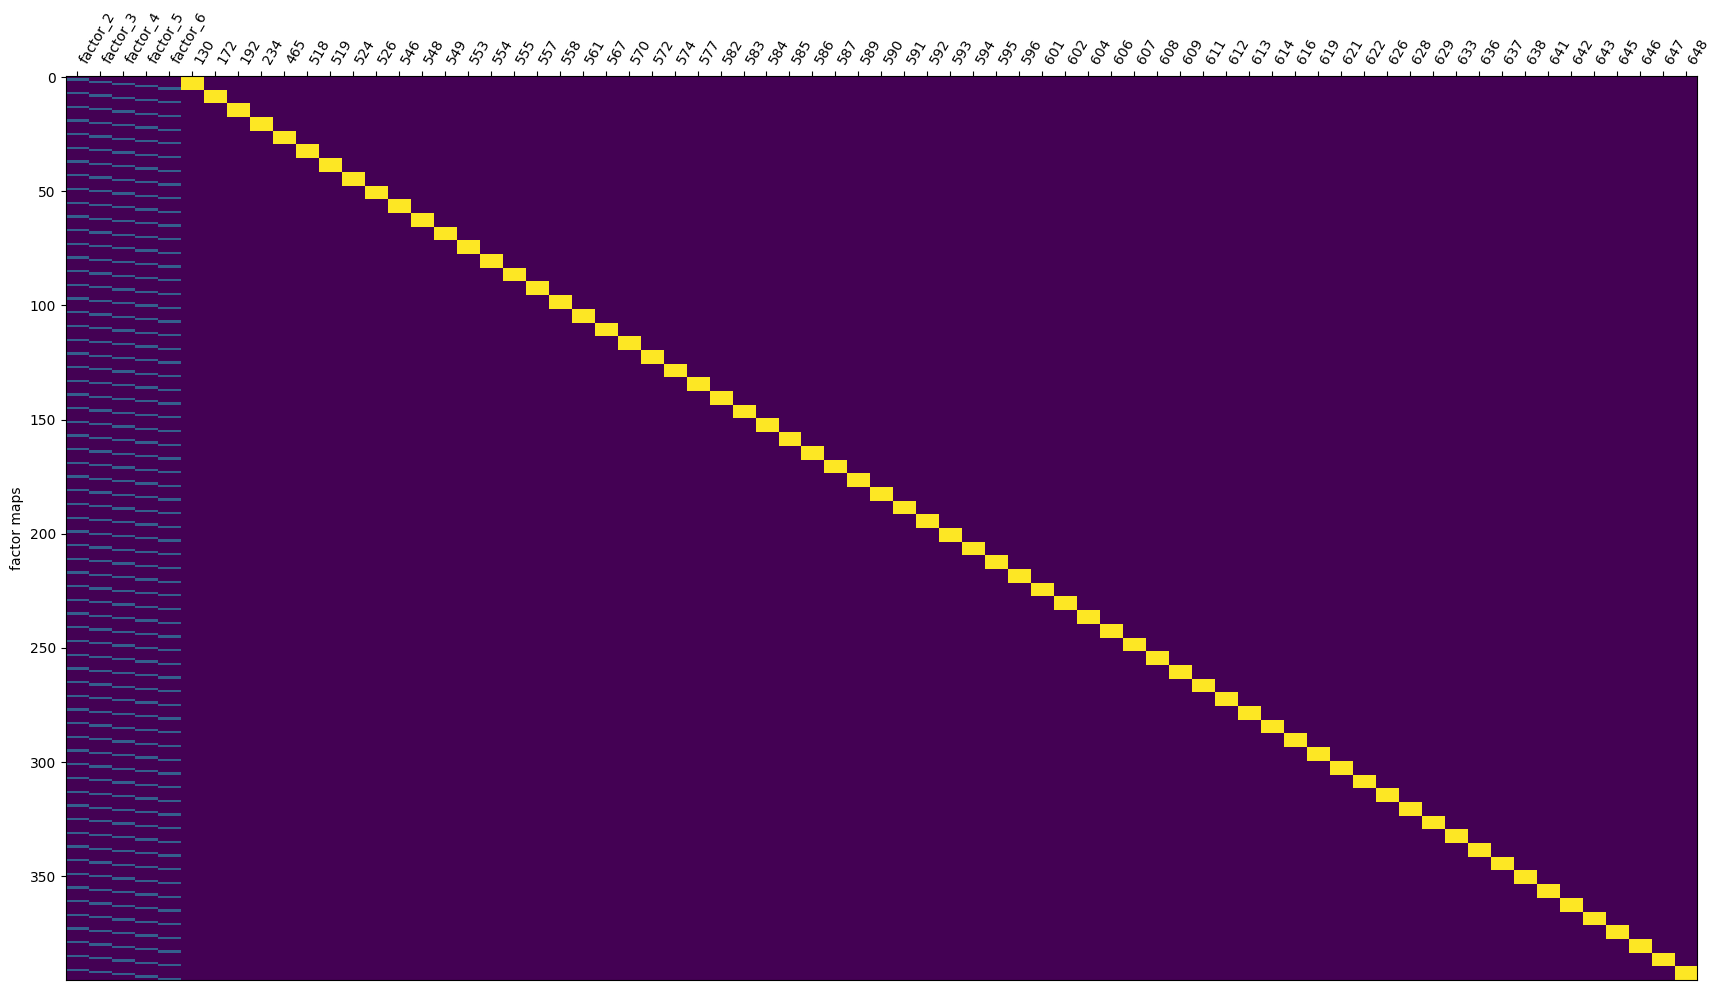

In [2]:
import pandas as pd
from nilearn.plotting import plot_design_matrix, plot_stat_map
import matplotlib.pyplot as plt
import numpy as np

design_matrix = pd.DataFrame()
# First 5 columns are dummy regressors for factors 2-6
one_indices = []
for i in range(len(sub_ids)):
    one_indices.append(1 + num_factors * i)
for i in range(num_factors - 1):
    one_indices_updated = [x + i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[f"factor_{i + 2}"] = col
# The other 66 columns are dummy regressors for each subject
one_indices = [0, 1, 2, 3, 4, 5]
for i in range(len(sub_ids)):
    one_indices_updated = [x + num_factors * i for x in one_indices]
    col = [1 if j in one_indices_updated else 0 for j in range(len(sorted_bold_files))]
    design_matrix[sub_ids[i]] = col

rank = np.linalg.matrix_rank(design_matrix.values)
num_columns = len(design_matrix.columns)
print("rank:", rank)
print("number of columns in design matrix:", num_columns)

design_matrix_plot = plot_design_matrix(design_matrix)
design_matrix_plot.set_ylabel("factor maps")
plt.show()

# Create contrast

In [3]:
#######
print(contrast)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

# Specify and run second level model

In [4]:
from nilearn.glm.second_level import SecondLevelModel
import nibabel as nf

model = SecondLevelModel(n_jobs=2)
model.fit(sorted_bold_files, design_matrix=design_matrix)
f_stat_map = model.compute_contrast(second_level_contrast=contrast, second_level_stat_type='F', output_type='stat')
nf.save(f_stat_map, 'factor_maps_f_test_f_stat.nii.gz')

z_map = model.compute_contrast(second_level_contrast=contrast, second_level_stat_type='F', output_type='z_score')
nf.save(z_map, 'factor_maps_f_test_z_score.nii.gz')

# Get clusters from F-statistic maps
Get the cluster tables for both thresholds (p < 0.05 and p < 0.0005)

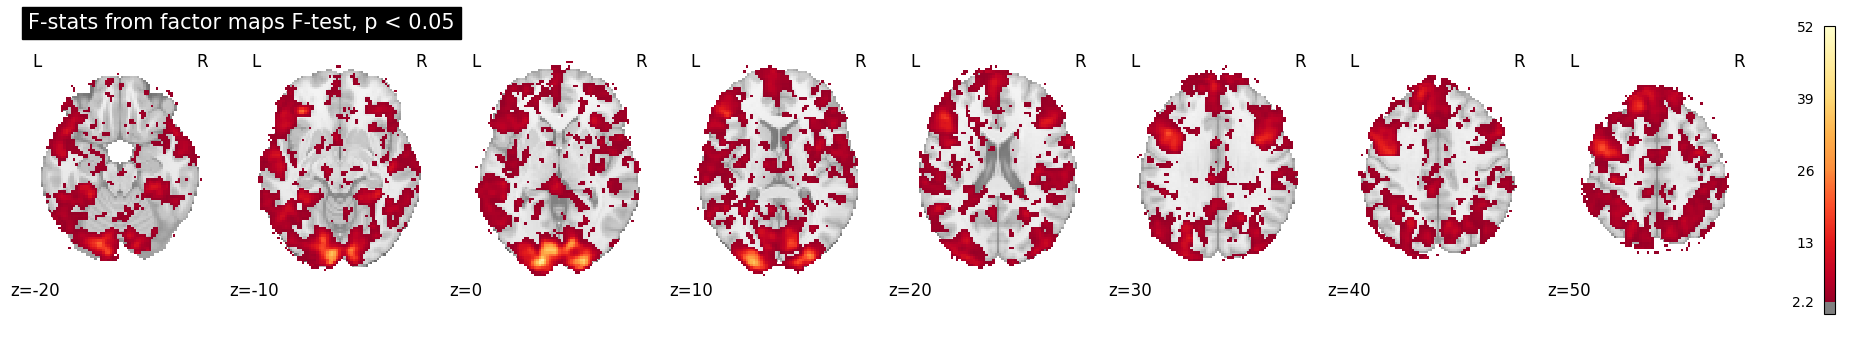

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Cluster Size (vox)
0,1,-8.499998,-90.699999,-3.699998,51.638135,694579,65231
1,2,-1.899998,6.100003,29.300002,7.333019,958,90
2,3,15.700002,-46.699998,-45.499999,7.285395,4035,379
3,4,20.100003,34.700004,-23.499999,6.879714,351,33
4,5,-32.699999,-70.899999,-52.099999,6.689212,628,59
...,...,...,...,...,...,...,...
971,972,17.900002,45.700004,24.900002,2.244413,10,1
972,973,61.900003,-18.099998,-30.099999,2.243578,10,1
973,974,24.500003,14.900003,-49.899999,2.242832,10,1
974,975,-15.099998,-86.299999,-49.899999,2.242411,10,1


In [17]:
from scipy.stats import f

# Degrees of freedom
df_num = contrast.shape[0]
df_den = design_matrix.shape[0] - design_matrix.shape[1]

# F thresholds for p = 0.05 and p = 0.0005 (right-tail)
f_p_05 = f.isf(0.05, df_num, df_den)
f_p_0005 = f.isf(0.0005, df_num, df_den)

from nilearn.reporting import get_clusters_table

z_slices = [-20, -10, 0, 10, 20, 30, 40, 50]
plot_stat_map(f_stat_map,
                display_mode='z',
                cut_coords=z_slices,
                threshold=f_p_05,
                colorbar=True,
                cmap='YlOrRd_r', 
                title=f'F-stats from factor maps F-test, p < 0.05'
            )
plt.show()

cluster_table_p_05 = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_05,   # F-stat threshold
    cluster_threshold=0,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500
)
cluster_table_p_05['Cluster Size (mm3)'] = pd.to_numeric(cluster_table_p_05['Cluster Size (mm3)'])
cluster_table_p_05['Cluster Size (vox)'] = np.round(cluster_table_p_05['Cluster Size (mm3)'] / 10.648).astype(int)
pd.reset_option('display.max_rows')
cluster_table_p_05

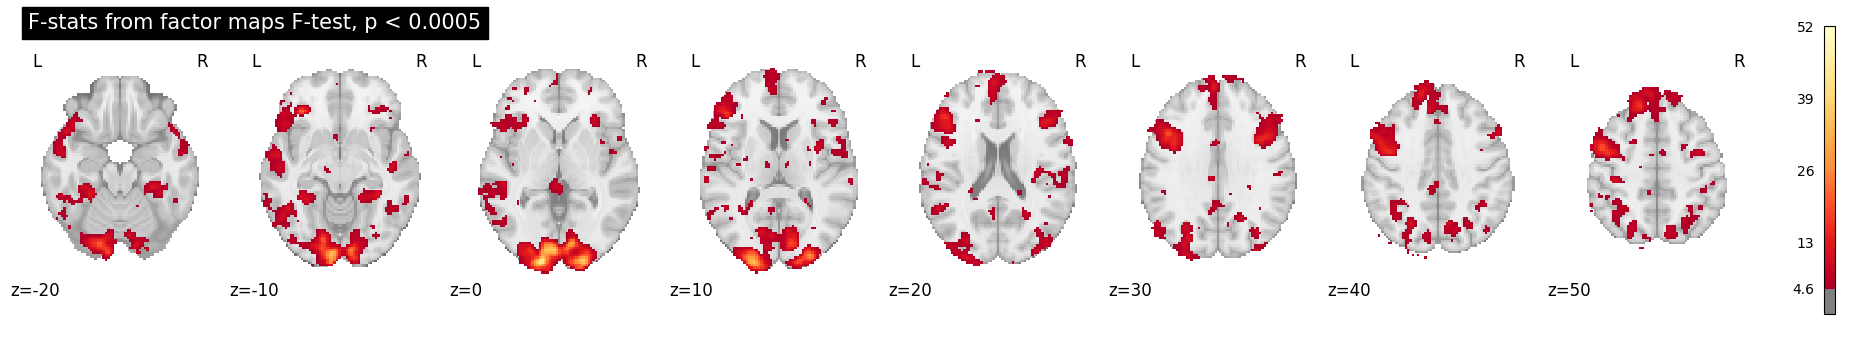

,Cluster ID,X,Y,Z,Peak Stat,Cluster Size (mm3),Cluster Size (vox)
0,1,-8.499998,-90.699999,-3.699998,51.638135,76857,7218
1,2,-32.699999,34.700004,-10.299999,22.425843,55657,5227
2,3,-17.299998,39.100004,51.300003,18.477723,29516,2772
3,4,37.700003,8.300003,29.300002,15.585586,9764,917
4,5,35.500003,-40.099998,-12.499999,13.163657,3641,342
5,6,-39.299999,-29.099998,53.500003,12.771227,4791,450
6,7,33.300003,23.700003,-3.699998,12.037424,2055,193
7,8,-1.899998,-31.299998,-1.499998,11.212178,1054,99
8,9,-54.699999,-53.299998,18.300002,10.696910,1937,182
9,10,-32.699999,-55.499998,7.300002,10.551364,734,69


In [19]:
plot_stat_map(f_stat_map,
                display_mode='z',
                cut_coords=z_slices,
                threshold=f_p_0005,
                colorbar=True,
                cmap='YlOrRd_r', 
                title=f'F-stats from factor maps F-test, p < 0.0005'
            )
plt.show()

cluster_table_p_0005 = get_clusters_table(
    stat_img=f_stat_map,
    stat_threshold=f_p_0005,   # F-stat threshold
    cluster_threshold=0,     # min cluster size in voxels (set >0 to filter)
    two_sided=False,            # F-tests are always positive
    min_distance=500
)
cluster_table_p_0005['Cluster Size (mm3)'] = pd.to_numeric(cluster_table_p_0005['Cluster Size (mm3)'])
cluster_table_p_0005['Cluster Size (vox)'] = np.round(cluster_table_p_0005['Cluster Size (mm3)'] / 10.648).astype(int)
pd.set_option('display.max_rows', None)
cluster_table_p_0005